In [1]:
%matplotlib inline

import os
import time
import math
import glob
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

from pathlib import Path
from torch.utils.data import Dataset, DataLoader, sampler
from torch.cuda.amp import GradScaler, autocast
from PIL import Image

import torch
from torch.nn import functional as F
from torch.autograd import Variable

##############################
from models import deeplab_resnet_hyper
from models import deeplab_xception
from datasets import datasets

from utils import manager as mgr
from utils import metrics
from utils import losses
from utils import log
from utils import img_utils
##############################

nr_classes = 4
nr_channels = 7
exp_name = 'deeplab_std_resnet_dc_256_3_os8_flip_mask_ac1'
DEVICE = "cuda:0"
WEIGHTS_PATH = 'weights/' + exp_name + '/'

backbone = 'resnet' #'xception'#'resnet'

# set device
#device = torch.device(DEVICE if torch.cuda.is_available() else "cpu")
device = "cuda:0"
device_nr = int(device[-1])
#device = "cpu"
print(device)

# batch size (256) 56, (512) 15
batch_size = 24 #40 #56 #15
split={'train':0.7, 'val':0.1, 'test':0.2}
num_workers = 4
pin_memory = True

LR = 0.001
LR_DECAY = 0.995
DECAY_EVERY_N_EPOCHS = 1
N_EPOCHS = 1
start_epoch = 1

cuda:0


In [2]:
torch.cuda.empty_cache()


path_dataset = "/media/philipp/DATA/dataset/dataset_512_df_177.h5"
ground_truth = 'ground_truth_std'

nr_classes = 4
cr = 48
dsize = 256
ddepth = 3
os = 16
up = 256
input_chn=['ortho', 'dsm', 'dtm', 'slope']

# backbone
if exp_name == 'deeplab_std_xception':
    WEIGHTS_FILE = 'weights-14-0.155-0.876.pth'
    backbone = 'xception'  
elif exp_name == 'deeplab_std_resnet':
    WEIGHTS_FILE = 'weights-23-0.147-0.887.pth'
    backbone = 'resnet'

# CR
elif exp_name == 'deeplab_std_resnet_cr32':
    WEIGHTS_FILE = 'weights-22-0.149-0.886.pth'
    backbone = 'resnet'
    cr = 32
elif exp_name == 'deeplab_std_resnet_cr64':
    WEIGHTS_FILE = 'weights-11-0.148-0.885.pth'
    backbone = 'resnet'
    cr = 64

# upsample
elif exp_name == 'deeplab_std_resnet_dc_512_3_up_512':
    WEIGHTS_FILE = 'weights-45-0.149-0.886.pth'
    backbone = 'resnet'
    up = 512
    dsize = 512    
    
# decoder channels
elif exp_name == 'deeplab_std_resnet_dc_128_3':
    WEIGHTS_FILE = 'weights-33-0.151-0.885.pth'
    backbone = 'resnet'
    dsize = 128
elif exp_name == 'deeplab_std_resnet_dc_512_3':
    WEIGHTS_FILE = 'weights-15-0.148-0.886.pth'
    backbone = 'resnet'
    dsize = 512
elif exp_name == 'deeplab_std_resnet_dc_1024_3':
    WEIGHTS_FILE = 'weights-25-0.151-0.883.pth'
    backbone = 'resnet'
    dsize = 1024

# decoder layers
elif exp_name == 'deeplab_std_resnet_dc_256_4':
    WEIGHTS_FILE = 'weights-43-0.149-0.886.pth'
    backbone = 'resnet'
    ddepth = 4
elif exp_name == 'deeplab_std_resnet_dc_256_5':
    WEIGHTS_FILE = 'weights-32-0.150-0.879.pth'
    backbone = 'resnet'
    ddepth = 5
elif exp_name == 'deeplab_std_resnet_dc_512_4':
    WEIGHTS_FILE = 'weights-30-0.148-0.882.pth'
    backbone = 'resnet'
    dsize = 512
    ddepth = 4
    
# OS
elif exp_name == 'deeplab_std_resnet_dc_256_3_os8':
    WEIGHTS_FILE = 'weights-40-0.147-0.881.pth'
    backbone = 'resnet'
    os = 8
    
# input 512x512
elif exp_name == 'deeplab_std_resnet_in_512x512':
    WEIGHTS_FILE = 'weights-19-0.152-0.887.pth'
    backbone = 'resnet'
    
# flip
elif exp_name == 'deeplab_std_resnet_flip':
    WEIGHTS_FILE = 'weights-32-0.137-0.894.pth'
    #WEIGHTS_FILE = 'weights-46-0.134-0.897.pth'
    backbone = 'resnet'
elif exp_name == 'deeplab_std_resnet_dc_256_3_os8_flip':
    WEIGHTS_FILE = 'weights-27-0.135-0.894.pth'
    #WEIGHTS_FILE = 'weights-37-0.130-0.895.pth'
    #WEIGHTS_FILE = 'weights-46-0.129-0.898.pth'
    backbone = 'resnet'
    os = 8

    # mask
elif exp_name == 'deeplab_std_resnet_dc_256_3_os8_flip_mask_std':
    path_dataset = "/media/philipp/DATA/dataset/dataset_mask_512_df_177.h5"
    ground_truth = 'ground_truth_std_mask'
    WEIGHTS_FILE = 'weights-41-0.338-0.907.pth'
    backbone = 'resnet'
    #nr_classes = 3
    os = 8
    
    
# ac1 & ac12
elif exp_name == 'deeplab_std_resnet_dc_256_3_os8_flip_ac1':
    ground_truth = 'ground_truth_ac1'
    WEIGHTS_FILE = 'weights-47-0.219-0.871.pth'
    backbone = 'resnet'
    os = 8
elif exp_name == 'deeplab_std_resnet_dc_256_3_os8_flip_ac12':
    ground_truth = 'ground_truth_ac12'
    WEIGHTS_FILE = 'weights-42-0.273-0.824.pth'
    backbone = 'resnet'
    nr_classes = 5
    os = 8
    
# mask ac1 & mask ac12
elif exp_name == 'deeplab_std_resnet_dc_256_3_os8_flip_mask_ac1':
    path_dataset = "/media/philipp/DATA/dataset/dataset_mask_512_df_177.h5"
    ground_truth = 'ground_truth_ac1_mask'
    WEIGHTS_FILE = 'weights-40-0.441-0.848.pth'
    backbone = 'resnet'
    nr_classes = 4
    os = 8
elif exp_name == 'deeplab_std_resnet_dc_256_3_os8_flip_mask_ac12':
    path_dataset = "/media/philipp/DATA/dataset/dataset_mask_512_df_177.h5"
    ground_truth = 'ground_truth_ac12_mask'
    WEIGHTS_FILE = 'weights-40-0.436-0.837.pth'
    backbone = 'resnet'
    nr_classes = 5
    os = 8
    

# ablation
elif exp_name == 'deeplab_std_resnet_ab_dsm':
    WEIGHTS_FILE = 'weights-42-0.151-0.876.pth'
    backbone = 'resnet'
    input_chn=['ortho', 'dtm', 'slope']
    nr_channels = 6
    os = 8
elif exp_name == 'deeplab_std_resnet_ab_dtm':
    WEIGHTS_FILE = 'weights-47-0.140-0.885.pth'
    backbone = 'resnet'
    input_chn=['ortho', 'dsm', 'slope']
    nr_channels = 6
    os = 8
elif exp_name == 'deeplab_std_resnet_ab_dtm_slope':
    WEIGHTS_FILE = 'weights-45-0.150-0.882.pth'
    backbone = 'resnet'
    input_chn=['ortho', 'dsm']
    nr_channels = 5
    os = 8
elif exp_name == 'deeplab_std_resnet_ab_ortho':
    WEIGHTS_FILE = 'weights-49-0.161-0.862.pth'
    backbone = 'resnet'
    input_chn=['dsm', 'dtm', 'slope']
    nr_channels = 3
    os = 8
elif exp_name == 'deeplab_std_resnet_ab_ortho_dsm':
    WEIGHTS_FILE = 'weights-46-0.273-0.725.pth'
    backbone = 'resnet'
    input_chn=['dtm', 'slope']
    nr_channels = 2
    os = 8
elif exp_name == 'deeplab_std_resnet_ab_slope':
    WEIGHTS_FILE = 'weights-36-0.154-0.881.pth'
    backbone = 'resnet'
    input_chn=['ortho', 'dsm', 'dtm']
    nr_channels = 6
    os = 8
elif exp_name == 'deeplab_std_resnet_ab_dsm_dtm_slope':
    WEIGHTS_FILE = 'weights-40-0.157-0.872.pth'
    backbone = 'resnet'
    input_chn=['ortho']
    nr_channels = 4
    os = 8

In [3]:
## Creating the dataset
#path_dataset = "/media/philipp/DATA/dataset/dataset_256_df_177.h5"
#path_dataset = "/media/philipp/DATA/dataset/dataset_512_df_177.h5"
#path_dataset = "/media/philipp/DATA/dataset/dataset_mask_512_df_177.h5"
dataset = datasets.ForestDataset(path_dataset, ground_truth=ground_truth, inputs=input_chn)

if dataset[0][0].shape[1] == 256:
    chunk_size = 1000
else:
    chunk_size = 0

# shuffle and split
train_sampler, val_sampler, test_sampler = dataset.get_sampler(split=split, \
                shuffle_dataset=True, random_seed=399, chunk_size=chunk_size, fold=0)

# dataloader
train_dl = torch.utils.data.DataLoader(dataset, batch_size=batch_size, \
                                sampler=train_sampler, num_workers=num_workers, pin_memory=pin_memory)
val_dl = torch.utils.data.DataLoader(dataset, batch_size=batch_size, \
                                sampler=val_sampler, num_workers=num_workers, pin_memory=pin_memory)
test_dl = torch.utils.data.DataLoader(dataset, batch_size=batch_size, \
                                sampler=test_sampler, num_workers=num_workers, pin_memory=pin_memory)
print(len(dataset))
print(len(train_sampler.indices))
print(len(val_sampler.indices))
print(len(test_sampler.indices))

10679
7477
1067
2135


In [4]:
# show examples
#img_utils.view_sample(train_dl, 10)

In [5]:
#############
#   train
#############
def train(model, trn_loader, optimizer, criterion, epoch):
    
    model.train()
    step = 0
    metric = {'loss': 0.0, \
              'acc_all':0.0, \
              'acc_mean':0.0, \
              'jacc':0.0, \
              'dice':0.0}

    for idx, data in enumerate(trn_loader):
        x = Variable(data[0].to(device))
        y = Variable(data[1].to(device))
        step += 1
        
        # forward pass
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        
        # backward pass
        loss.backward()
        # update weights
        optimizer.step()

        # calculate predictions
        pred = mgr.get_predictions(output)
        
        # calculate metrics for the batch
        overall_acc, avg_per_class_acc, avg_jacc, avg_dice = metrics.eval_metrics(y, pred, num_classes=nr_classes, device=device)
        # update running metrics
        for i, m in zip(metric, [loss, overall_acc, avg_per_class_acc, avg_jacc, avg_dice]):
            metric[i] += m*trn_loader.batch_size
        
        # print metrics to console
        if step % 100 == 0:
            print('Step: {}  Loss: {:.4f}  Acc all: {:.4f}  Acc mean: {:.4f}  IoU: {:.4f}  Dice: {:.4f}'\
                  .format(step, loss, overall_acc, avg_per_class_acc, avg_jacc, avg_dice))
    
    # calculate metrics for the epoch      
    for i in metric:
        metric[i] /= len(train_sampler.indices)
                    
    return metric

#############
#   test
#############
def test(model, test_loader, criterion, epoch=1):
    
    model.eval()
    step = 0
    metric = {'loss': 0.0, \
              'acc_all':0.0, \
              'acc_mean':0.0, \
              'jacc':0.0, \
              'dice':0.0}
    cm = torch.zeros((nr_classes, nr_classes))
    
    for data, target in test_loader:
        x = Variable(data.to(device))
        y = Variable(target.to(device))
        step += 1
        
        # forward pass
        with torch.no_grad():
            output = model(x)
            loss = criterion(output, y)
            #test_loss += criterion(output, y).data.item()
            
        # calculate predictions    
        pred = mgr.get_predictions(output)
        
        # calculate metrics for the batch
        overall_acc, avg_per_class_acc, avg_jacc, avg_dice, cm_b = metrics.eval_metrics(y, pred, num_classes=nr_classes, device=device, cm=True)
        # update running metrics
        for i, m in zip(metric, [loss, overall_acc, avg_per_class_acc, avg_jacc, avg_dice]):
            metric[i] += m*test_loader.batch_size
        cm += cm_b
            
        # print metrics to console
        if step % 100 == 0:
            print('Step: {}  Loss: {:.4f}  Acc all: {:.4f}  Acc mean: {:.4f}  IoU: {:.4f}  Dice: {:.4f}'\
                  .format(step, loss, overall_acc, avg_per_class_acc, avg_jacc, avg_dice))
        
    # calculate metrics for the epoch
    for i in metric:
        metric[i] /= len(val_sampler.indices)
                    
    return metric, cm

In [6]:
#############
#   test 
#############
def test(model, test_loader, criterion, epoch=1):
    
    model.eval()
    step = 0
    metric = {'loss': 0.0, \
              'acc_all':0.0, \
              'acc_mean':0.0, \
              'jacc':0.0, \
              'dice':0.0}
    cm = torch.zeros((nr_classes, nr_classes))
    
    for data, target in test_loader:
        x = Variable(data.to(device))
        y = Variable(target.to(device))
        step += 1
        
        # forward pass
        with torch.no_grad():
            output = model(x)
            loss = criterion(output, y)
            #test_loss += criterion(output, y).data.item()
            
        # calculate predictions    
        pred = mgr.get_predictions(output)
        
        # calculate metrics for the batch
        overall_acc, avg_per_class_acc, avg_jacc, avg_dice, cm_b = metrics.eval_metrics(y, pred, num_classes=nr_classes, device=device, cm=True)
        # update running metrics
        for i, m in zip(metric, [loss, overall_acc, avg_per_class_acc, avg_jacc, avg_dice]):
            metric[i] += m*test_loader.batch_size
        cm += cm_b
            
        # print metrics to console
        if step % 100 == 0:
            print('Step: {}  Loss: {:.4f}  Acc all: {:.4f}  Acc mean: {:.4f}  IoU: {:.4f}  Dice: {:.4f}'\
                  .format(step, loss, overall_acc, avg_per_class_acc, avg_jacc, avg_dice))
        
    # calculate metrics for the epoch
    for i in metric:
        metric[i] /= len(val_sampler.indices)
                    
    return metric, cm

In [7]:
from pathlib import Path
path_to_file = '/home/philipp/Code/work/model_deeplab/'+WEIGHTS_PATH+WEIGHTS_FILE
path = Path(path_to_file)
path.is_file()

True

In [8]:
# Network definition
if backbone == 'xception':
    model = deeplab_xception.DeepLabv3_plus(nInputChannels=nr_channels, \
                                            n_classes=nr_classes, os=os, pretrained=False)
elif backbone == 'resnet':
    model = deeplab_resnet_hyper.DeepLabv3_plus(nInputChannels=nr_channels, \
                                                n_classes=nr_classes, os=os, \
                                                pretrained=False, \
                                                cr=cr, \
                                                dsize=dsize, \
                                                up=up, \
                                                ddepth=ddepth)
else:
    raise NotImplementedError

try:
    map_location = {'cuda:1':'cuda:0'}
    start_epoch = mgr.load_weights(model, '/home/philipp/Code/work/model_deeplab/' + \
                                   WEIGHTS_PATH + WEIGHTS_FILE, map_location)
    #load_weights(model, WEIGHTS_PATH+'latest_5d.pt')
    print("weights loaded")
except:
    #model.apply(weights_init)
    #os.makedirs(WEIGHTS_PATH, exist_ok=True) 
    print("no weights found")

torch.cuda.set_device(device=device_nr)
model.cuda()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
#optimizer = optim.SGD(net.parameters(), lr=p['lr'], momentum=p['momentum'], weight_decay=p['wd'])
criterion = losses.Dice_Loss()
#criterion = torch.nn.CrossEntropyLoss()

#    
#if resume_epoch == 0:
#    print("Training deeplabv3+ from scratch...")
#else:
#    print("Initializing weights from: {}...".format(
#        os.path.join(save_dir, 'models', modelName + '_epoch-' + str(resume_epoch - 1) + '.pth')))
#    net.load_state_dict(
#        torch.load(os.path.join(save_dir, 'models', modelName + '_epoch-' + str(resume_epoch - 1) + '.pth'),
#                   map_location=lambda storage, loc: storage)) # Load all tensors onto the CPU

Constructing DeepLabv3+ model...
Number of classes: 4
Output stride: 8
Number of Input Channels: 7
loading weights '/home/philipp/Code/work/model_deeplab/weights/deeplab_std_resnet_dc_256_3_os8_flip_mask_ac1/weights-40-0.441-0.848.pth'
loaded weights (lastEpoch 40, loss 0.440763920545578, error 0.8480415940284729)
weights loaded


In [9]:
def calc_mertics(cm_test, labels):
    labels_m = labels.copy()
    labels_m.append('mean')
    
    true_pos = np.diag(cm_test) 
    precision = true_pos / np.sum(cm_test, axis=0)
    recall = true_pos / np.sum(cm_test, axis=1)
    F1 = 2 * (precision * recall) / (precision + recall)
    
    cm_test_plus = np.zeros((4,cm_test.shape[0]+1))
    cm_test_plus[0,:-1] = precision
    cm_test_plus[1,:-1] = recall
    cm_test_plus[3,:-1] = F1
    
    cm_test_plus[0,-1:] = np.mean(precision)
    cm_test_plus[1,-1:] = np.mean(recall)
    cm_test_plus[3,-1:] = np.mean(F1)

    # Acc all
    acc_all = true_pos.sum()/cm_test.sum()

    # Acc mean
    acc_mean = np.mean(true_pos/cm_test.sum(axis=1))

    # IoU
    false_neg = np.sum(cm_test, axis=0)-true_pos
    false_pos = np.sum(cm_test, axis=1)-true_pos
    iou = true_pos/(true_pos+false_pos+false_neg)
    miou = np.mean(true_pos/(true_pos+false_pos+false_neg))
    
    cm_test_plus[2,:-1] = iou
    cm_test_plus[2,-1:] = miou

    # Dice
    dice = np.mean(F1)
    
    # create dataframes
    df_test = pd.DataFrame(cm_test/10**6, index=labels, columns=labels)
    df_test = df_test.round(1)#.astype(int)
    
    df_test_plus = pd.DataFrame(cm_test_plus, index=['precision [%]', 'recall [%]', 'IoU [%]', 'F1 [%]'], columns=labels_m)
    df_test_plus = (df_test_plus*100).round(2)
    
    df_test_metrics = pd.DataFrame([[acc_all, acc_mean, miou, dice]], \
                       columns=['Acc all', 'Acc mean', 'IoU/Jacc', 'Dice/F1'])
    df_test_metrics = (df_test_metrics*100).round(2)
    
    return df_test, df_test_plus, df_test_metrics

In [10]:
def calc_mertics_void(cm_test, labels):
    labels_m = labels.copy()
    labels_m.append('mean')
    
    true = np.diag(cm_test) 
    precision = true / np.sum(cm_test, axis=0)
    recall = true / np.sum(cm_test, axis=1)
    F1 = 2 * (precision * recall) / (precision + recall)
    
    cm_test_plus = np.zeros((4,cm_test.shape[0]+1))
    cm_test_plus[0,:-1] = precision
    cm_test_plus[1,:-1] = recall
    cm_test_plus[2,:-1] = F1
    
    cm_test_plus[0,-1:] = np.mean(precision[1:])
    cm_test_plus[1,-1:] = np.mean(recall[1:])
    cm_test_plus[2,-1:] = np.mean(F1[1:])

    # Acc all
    acc_all = true[1:].sum()/cm_test[1:].sum()

    # Acc mean
    acc_mean = np.mean(true[1:]/cm_test[1:,1:].sum(axis=1))

    # IoU
    false_neg = np.sum(cm_test, axis=0)-true
    false_pos = np.sum(cm_test, axis=1)-true
    iou = true/(true+false_pos+false_neg)
    miou = np.mean(true[1:]/(true[1:]+false_pos[1:]+false_neg[1:]))
    
    cm_test_plus[3,:-1] = iou
    cm_test_plus[3,-1:] = miou

    # Dice
    dice = np.mean(F1[1:])
    
    # create dataframes
    df_test = pd.DataFrame(cm_test/10**6, index=labels, columns=labels)
    df_test = df_test.round(1)#.astype(int)
    
    df_test_plus = pd.DataFrame(cm_test_plus, index=['precision [%]', 'recall [%]', 'F1 [%]', 'IoU [%]'], columns=labels_m)
    df_test_plus = df_test_plus.round(4)
    
    df_test_metrics = pd.DataFrame([[acc_all, np.mean(precision[1:]), np.mean(recall[1:]), miou, dice]], \
                       columns=['Acc all', 'precision', 'recall', 'IoU/Jacc', 'Dice/F1'])
    df_test_metrics = df_test_metrics.round(4)
    
    return df_test, df_test_plus, df_test_metrics

In [11]:
# val

In [12]:
metric, cm = test(model, val_dl, criterion, epoch=1)

/home/philipp/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/home/philipp/.local/lib/python3.8/site-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Step: 100  Loss: 0.0894  Acc all: 0.9049  Acc mean: 0.9040  IoU: 0.8414  Dice: 0.9105
Step: 200  Loss: 0.2000  Acc all: 0.8327  Acc mean: 0.8583  IoU: 0.6946  Dice: 0.8000


In [13]:
metric #256

{'loss': tensor(0.1500, device='cuda:0'),
 'acc_all': tensor(0.8851),
 'acc_mean': tensor(0.8544),
 'jacc': tensor(0.7686),
 'dice': tensor(0.8510)}

In [20]:
cmn, score, metric = calc_mertics_void(cm.numpy(), ['void', 'thinning', 'no_thinning', 'other'])

In [21]:
cmn

void  thinning  no_thinning  other
void           43         9           18      0
thinning        0        30           19      0
no_thinning     0        29          372      6
other           0         0            8     24

In [15]:
score

void  thinning  no_thinning   other    mean
precision [%]  0.9994    0.8030       0.9068  0.8453  0.8517
recall [%]     0.9709    0.7904       0.9274  0.7182  0.8120
F1 [%]         0.9849    0.7966       0.9170  0.7766  0.8301
IoU [%]        0.9703    0.6620       0.8467  0.6348  0.7145

In [16]:
metric

Acc all  precision  recall  IoU/Jacc  Dice/F1
0   0.8817     0.8517   0.812    0.7145   0.8301

In [11]:
# test

In [11]:
metric, cm = test(model, test_dl, criterion, epoch=1)

/home/philipp/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/home/philipp/.local/lib/python3.8/site-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [12]:
metric #256

{'loss': tensor(0.8403, device='cuda:0'),
 'acc_all': tensor(1.7378),
 'acc_mean': tensor(1.2054),
 'jacc': tensor(1.0171),
 'dice': tensor(1.1616)}

In [13]:
cmn, score, metric = calc_mertics_void(cm.numpy(), ['void', 'thinning1', 'no_thinning', 'other'])

<ipython-input-10-7d392179e3a6>:6: RuntimeWarning: invalid value encountered in true_divide
  precision = true / np.sum(cm_test, axis=0)
<ipython-input-10-7d392179e3a6>:7: RuntimeWarning: invalid value encountered in true_divide
  recall = true / np.sum(cm_test, axis=1)
<ipython-input-10-7d392179e3a6>:23: RuntimeWarning: invalid value encountered in true_divide
  acc_mean = np.mean(true[1:]/cm_test[1:,1:].sum(axis=1))
<ipython-input-10-7d392179e3a6>:28: RuntimeWarning: invalid value encountered in true_divide
  iou = true/(true+false_pos+false_neg)
<ipython-input-10-7d392179e3a6>:29: RuntimeWarning: invalid value encountered in true_divide
  miou = np.mean(true[1:]/(true[1:]+false_pos[1:]+false_neg[1:]))


In [14]:
cmn

void  thinning1  no_thinning  other
void         226.4        0.1         18.0    0.0
thinning1      0.0       30.0         18.4    0.0
no_thinning    0.1       37.1        229.4    0.0
other          0.0        0.0          0.0    0.0

In [15]:
score

void  thinning1  no_thinning  other  mean
precision [%]  0.9995     0.4464       0.8629    NaN   NaN
recall [%]     0.9257     0.6195       0.8604    NaN   NaN
F1 [%]         0.9612     0.5189       0.8617    NaN   NaN
IoU [%]        0.9253     0.3503       0.7569    NaN   NaN

In [16]:
metric

Acc all  precision  recall  IoU/Jacc  Dice/F1
0   0.8233        NaN     NaN       NaN      NaN

In [22]:
cmn, score, metric = calc_mertics_void(cm.numpy()[:3,:3], ['void', 'thinning', 'no_thinning'])

In [17]:
import numpy as np

In [17]:
cmm = np.array([[16, 24, 9, 0], [8, 48, 11, 0], [5, 31, 326, 6], [0, 1, 7, 24]])

In [27]:
cmm = np.array([[30, 19, 0], [29, 400, 6], [0, 8, 24]])

In [5]:
cmm = np.array([[97, 16], [29, 191]])

In [5]:
cmm = np.array([[93.2, 22.3, 0.8], [27.6, 333.2, 6.9], [0.9, 8, 23]])

In [23]:
cmm = np.array([[30, 18.4],
[37.2, 247.4]])

In [26]:
cmn, score, metric = calc_mertics(cmm, ['thinning', 'no_thinning', 'other'])

In [27]:
cmn

thinning  no_thinning
thinning          0.0          0.0
no_thinning       0.0          0.0

In [28]:
score

thinning  no_thinning   mean
precision [%]     44.64        93.08  68.86
recall [%]        61.98        86.93  74.46
IoU [%]           35.05        81.65  58.35
F1 [%]            51.90        89.90  70.90

In [29]:
metric

Acc all  Acc mean  IoU/Jacc  Dice/F1
0     83.3     74.46     58.35     70.9

In [28]:
########################

In [29]:
loader = test_dl

# get data
inputs, targets = next(iter(loader))
data = Variable(inputs.to(device))
label = Variable(targets.to(device))

# get predictions
with torch.no_grad():
    output = model(data)
pred = mgr.get_predictions(output)

/home/philipp/.local/lib/python3.8/site-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [30]:
inputs.shape

torch.Size([24, 7, 512, 512])

In [31]:
targets.shape

torch.Size([24, 512, 512])

In [32]:
pred.shape

torch.Size([24, 512, 512])

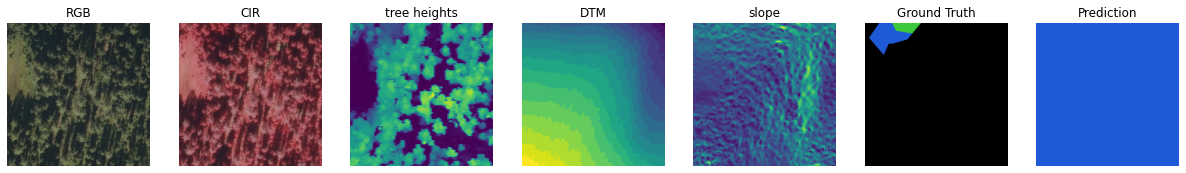

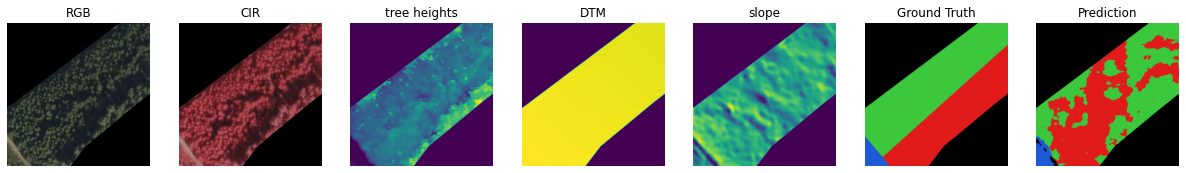

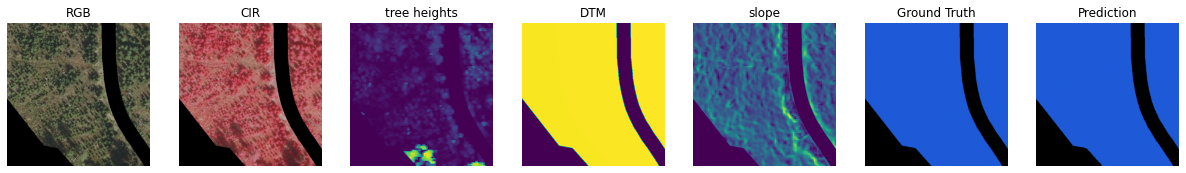

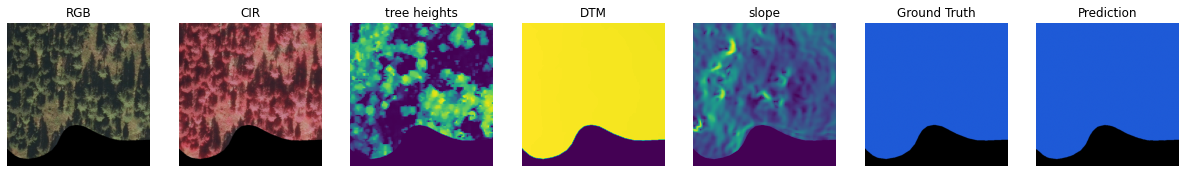

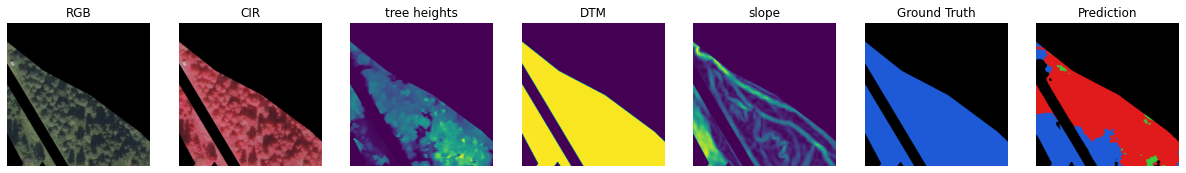

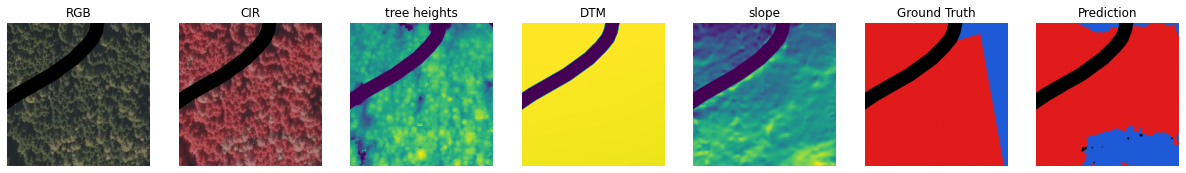

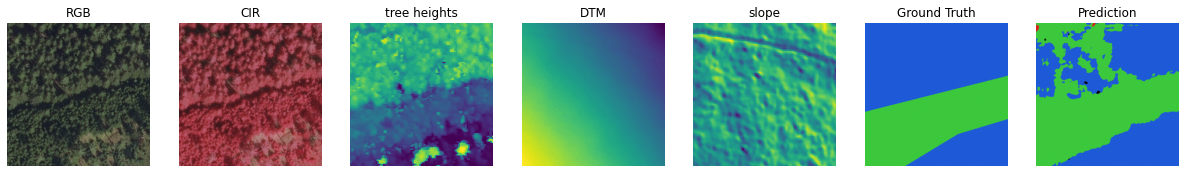

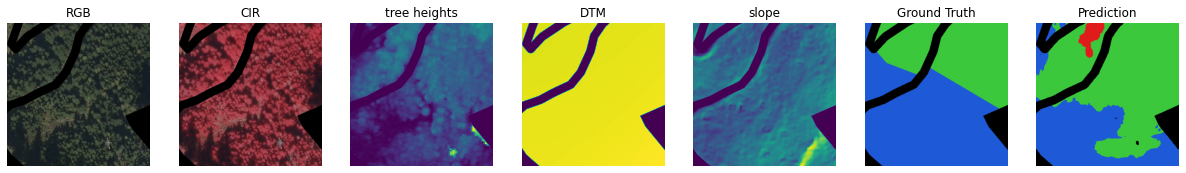

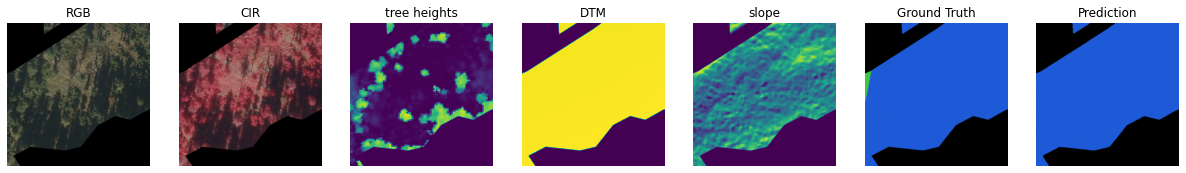

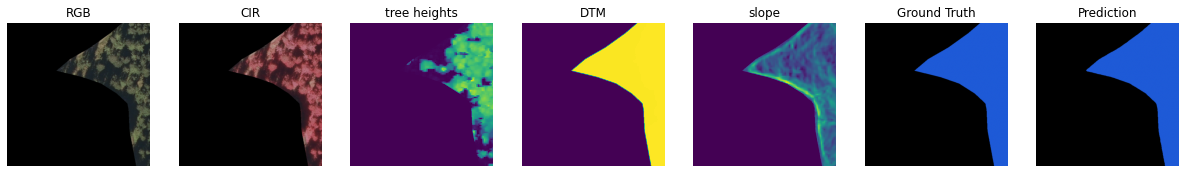

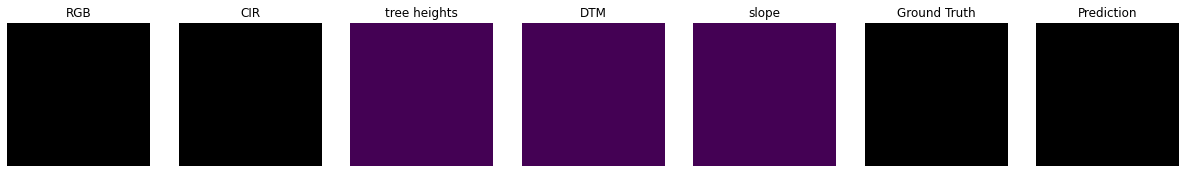

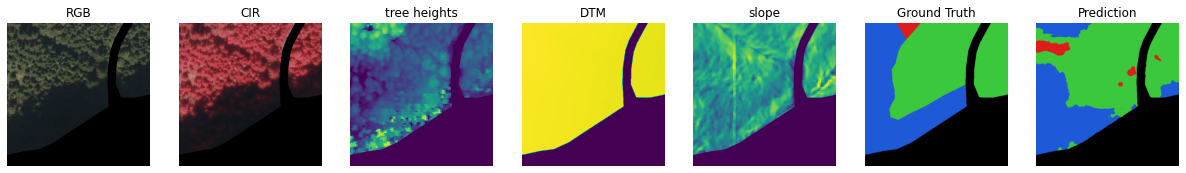

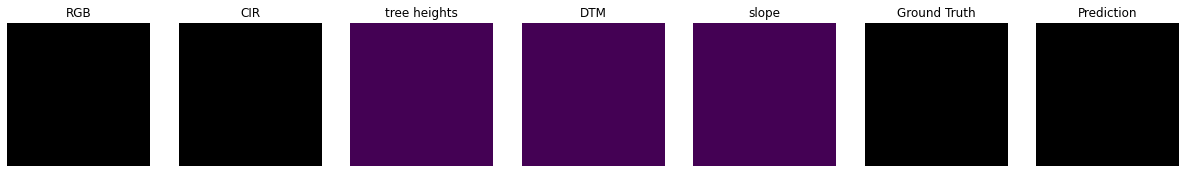

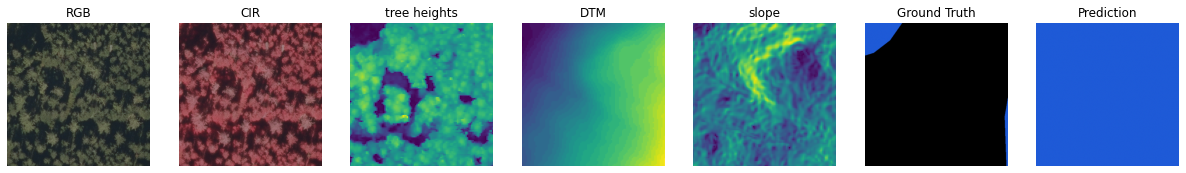

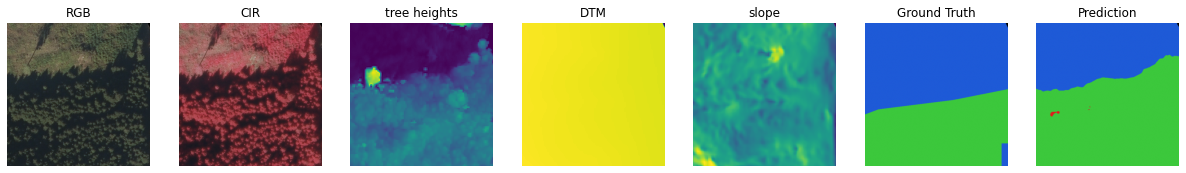

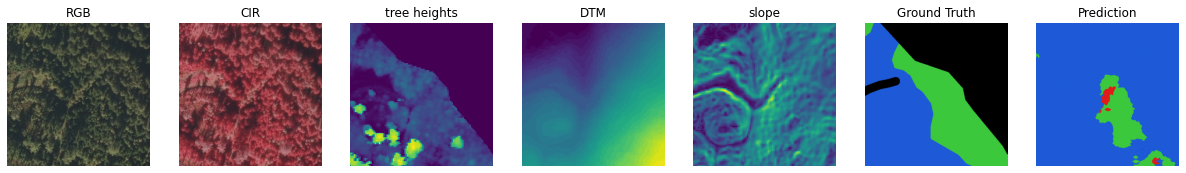

In [33]:
mgr.view_sample_predictions(model, loader=test_dl, n=16, device=device)

In [30]:
#######################################################################################

In [34]:
type_dict = {'rgb':'RGB', 'cir':'CIR', 'dsm':'CHM', 'dtm':'DTM', \
             'slope':'Slope', 'gt':'Ground Truth', 'pred':'Prediction'}

In [35]:
def plot_tile(inputs, typ='rgb'):
    
    dict_typ={'dsm':4, 'dtm':5, 'slope':6}
    
    if (typ == 'rgb') or (typ == 'cir'):
        fig, ax = plt.subplots(1,1, figsize=(9,9))
        ax.imshow(img_utils.decode_ortho(inputs[:4], typ))
        #ax.set_title(type_dict[typ])
        ax.axis('off')
        
    elif typ in ['dsm', 'dtm', 'slope']:
        fig, ax = plt.subplots(1,1, figsize=(9,9))
        ax.imshow(img_utils.decode_img(inputs[dict_typ[typ]], typ))
        #ax.set_title(type_dict[typ])
        ax.axis('off')
    
    elif typ in ['gt', 'pred']:
        fig, ax = plt.subplots(1,1, figsize=(9,9))
        ax.imshow(img_utils.view_annotated(inputs, plot=False, classes=nr_classes))
        #ax.set_title(type_dict[typ])
        ax.axis('off')
        

In [36]:
def plot_exp(inputs, trg, pred, nr_classes, typ='rgb'):
    
    fig, ax = plt.subplots(1,7, figsize=(21,9))
    ax[0].imshow(img_utils.decode_ortho(inputs[:4], 'rgb'))
    ax[0].set_title("RGB")
    ax[0].axis('off')
    ax[1].imshow(img_utils.decode_ortho(inputs[:4], 'cir'))
    ax[1].set_title("CIR")
    ax[1].axis('off')
    ax[2].imshow(img_utils.decode_img(inputs[4], 'dsm'))
    ax[2].set_title("tree heights")
    ax[2].axis('off')

    ax[3].imshow(img_utils.decode_img(inputs[5], 'dtm'))
    ax[3].set_title("DTM")
    ax[3].axis('off')
    ax[4].imshow(img_utils.decode_img(inputs[6], 'slope'))
    ax[4].set_title("slope")
    ax[4].axis('off')

    ax[5].imshow(img_utils.view_annotated(trg,plot=False, classes=nr_classes))
    ax[5].set_title("Ground Truth")
    ax[5].axis('off')
    ax[6].imshow(img_utils.view_annotated(pred,plot=False, classes=nr_classes))
    ax[6].set_title("Prediction")
    ax[6].axis('off')
    

In [37]:
def predict(inputs):
    # load data to device
    data = Variable(inputs.to(device))
    label = Variable(targets.to(device))
    # get predictions
    with torch.no_grad():
        output = model(data)
    pred = mgr.get_predictions(output)
    return pred

In [38]:
torch.cuda.empty_cache()

In [39]:
idx_test = test_sampler.indices

In [40]:
list_X = []
list_y = []
for i in range(150,180):
    list_X.append(dataset[idx_test[i]][0])
    list_y.append(dataset[idx_test[i]][1])
# create 
inputs = torch.stack(list_X)
targets = torch.stack(list_y)
predictions = predict(inputs)

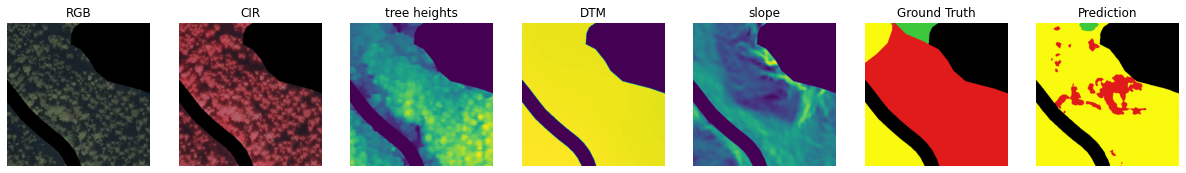

In [102]:
j=24

# load data
inp = inputs[j]
trg = targets[j]
pred = predictions[j]

# clean prediction
#pred[pred==0] = 2
#pred[pred==3] = 2
#pred[trg==0] = 0

plot_exp(inp, trg, pred, nr_classes=nr_classes, typ='rgb')

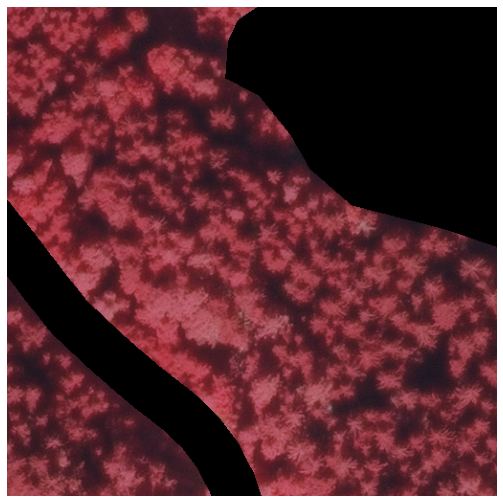

In [103]:
plot_tile(inp, typ='cir')

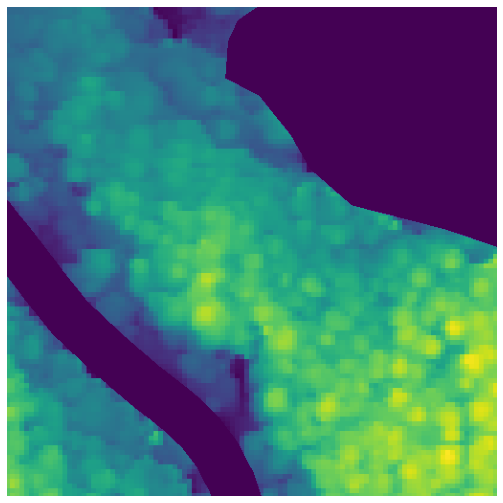

In [104]:
plot_tile(inp, typ='dsm')

In [105]:
#plot_tile(inp, typ='dtm')

In [106]:
#plot_tile(inp, typ='slope')

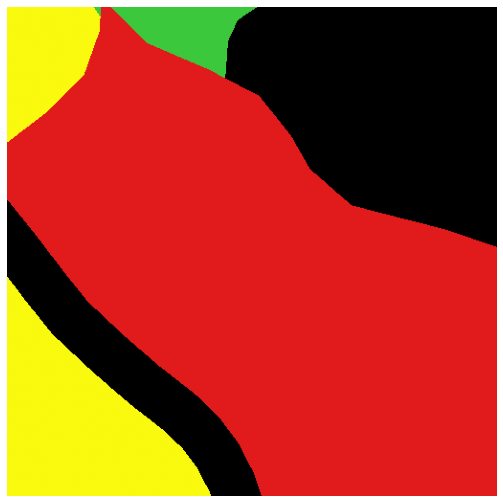

In [107]:
plot_tile(trg, typ='gt')

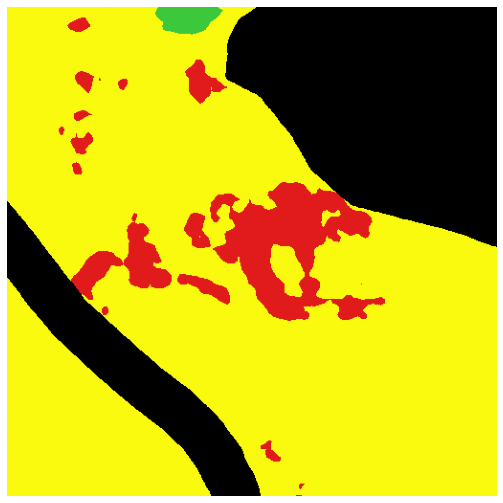

In [108]:
plot_tile(pred, typ='pred')

In [ ]:
#######################################################################################

In [607]:
def get_pixel(j):
    
    data_collector = []
    
    # define mean and std
    means_dsm = np.array([13.45], dtype='float32')
    stds_dsm = np.array([10.386633252098674], dtype='float32')
    
    # load data
    inp = inputs[j]
    trg = targets[j]
    pred = predictions[j]

    # clean prediction
    pred[pred==0] = 2
    pred[trg==0] = 0
    
    # create mask with errors
    mask_pos = trg == pred
    mask_neg = ~mask_pos
    
    for i in range(3):
        
        mask_type = trg == i
        
        for mask_pn in [mask_pos, mask_neg]:
            
            mask = mask_pn * mask_type
            err = inp * mask
            err_dsm = ((err[4][err[4]>0].numpy()) * stds_dsm) + means_dsm
            
            data_collector.append(err_dsm)
    
    return data_collector

In [608]:
dc = get_pixel(19)

In [612]:
len(dc)

6

In [611]:
np.concatenate(dc).shape

(188012,)

In [585]:
j=19

# load data
inp = inputs[j]
trg = targets[j]
pred = predictions[j]

# clean prediction
pred[pred==0] = 2
pred[trg==0] = 0

In [586]:
# create mask with errors
mask = trg == pred
#mask = ~mask
# filter errors
err = inp * mask

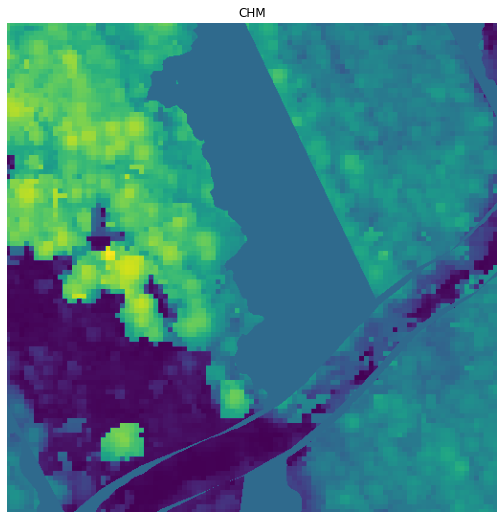

In [587]:
plot_tile(err, typ='dsm')

In [588]:
# define mean and std
means_dsm = np.array([13.45], dtype='float32')
stds_dsm = np.array([10.386633252098674], dtype='float32')

err_dsm = err[4][err[4]>0].numpy()
err_dsm = (err_dsm * stds_dsm) + means_dsm

In [589]:
print(err_dsm.shape)
print(err_dsm)

(147801,)
[28.15625 28.15625 28.15625 ... 18.71875 18.71875 18.71875]


In [581]:
# create mask with errors
mask = targets == predictions
mask = ~mask
# filter errors
err = inputs * mask.unsqueeze(1)

In [582]:
inputs.shape

torch.Size([30, 7, 512, 512])

In [514]:
mask.unsqueeze(1).shape

torch.Size([30, 1, 512, 512])

In [515]:
err.shape

torch.Size([30, 7, 512, 512])

In [524]:
# define mean and std
means_dsm = np.array([13.45], dtype='float32')
stds_dsm = np.array([10.386633252098674], dtype='float32')

# get dsm (layer 4)
#err_dsm = err[:,4].numpy().flatten()#[err[:,4]>0].numpy()
err_dsm = err[:,4][err[:,4]>0].numpy()
# denormalise
err_dsm = (err_dsm * stds_dsm) + means_dsm

In [531]:
# define mean and std
means_ir = np.array([119.50916281232037], dtype='float32')
stds_ir = np.array([49.301477498205074], dtype='float32')

# get dsm (layer 3)
err_ir = err[:,3].numpy().flatten()#[err[:,3]>0].numpy()
#err_ir = err[:,3][err[:,3]>0].numpy()
# denormalise
err_ir = (err_ir * stds_ir) + means_ir

In [533]:
err_ir.shape

(7864320,)

In [583]:
import matplotlib.pyplot as plt

(array([ 6727., 12017., 18611., 18827., 15359., 12083.,  8488.,  6245.,
         5458.,  7385.,  8284.,  7532.,  8035.,  5695.,  3140.,  2200.,
         1040.,   550.,    50.,    75.]),
 array([13.453125, 14.728907, 16.004688, 17.280468, 18.55625 , 19.832031,
        21.107813, 22.383595, 23.659374, 24.935156, 26.210938, 27.48672 ,
        28.7625  , 30.03828 , 31.314062, 32.589844, 33.865623, 35.141407,
        36.417187, 37.69297 , 38.96875 ], dtype=float32),
 <BarContainer object of 20 artists>)

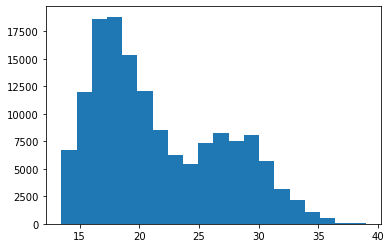

In [590]:
plt.hist(err_dsm, bins=20)

In [ ]:
#######################################################################################

In [90]:
def find_files(dir_img, data_types, sort=False):
    """
    find paths for provided data types
    inputs:
        dir_img (str) : directory path
        data_types (list) : list of data types to be included (exp: ['ortho', 'ground_truth'])
    return:
        paths (dictionary) : dictionary containing file paths for each of the data types
    """

    idxs = []
    # loop over all files found in directory and retrive indices
    for file in os.listdir("{}{}/".format(dir_img, data_types[0])):
        if file[-4:] == ".tif":
            idxs.append(file[file.rfind('_'):])

    if sort:
        idxs = sorted(idxs)

    paths = {}
    for data_type in data_types:
        paths[data_type] = []

    for idx in idxs:

        # check if index in all data types
        check_path = []
        for data_type in data_types:
            p = "{}{}/tile_{}{}".format(dir_img, data_type, data_type, idx)
            if os.path.isfile(p):
                check_path.append(p)

        if len(check_path) == len(data_types):
            for i, data_type in enumerate(data_types):
                paths[data_type].append(check_path[i])

    return paths

In [92]:
import os
find_files('/media/philipp/DATA/2018_tamsweg/', data_types=['ortho', 'dsm', 'dtm', 'slope'], sort=True)

{'ortho': ['/media/philipp/DATA/2018_tamsweg/ortho/tile_ortho_121889.tif',
  '/media/philipp/DATA/2018_tamsweg/ortho/tile_ortho_121890.tif',
  '/media/philipp/DATA/2018_tamsweg/ortho/tile_ortho_122277.tif',
  '/media/philipp/DATA/2018_tamsweg/ortho/tile_ortho_122278.tif',
  '/media/philipp/DATA/2018_tamsweg/ortho/tile_ortho_122279.tif',
  '/media/philipp/DATA/2018_tamsweg/ortho/tile_ortho_122280.tif',
  '/media/philipp/DATA/2018_tamsweg/ortho/tile_ortho_122647.tif',
  '/media/philipp/DATA/2018_tamsweg/ortho/tile_ortho_122648.tif',
  '/media/philipp/DATA/2018_tamsweg/ortho/tile_ortho_122649.tif',
  '/media/philipp/DATA/2018_tamsweg/ortho/tile_ortho_122650.tif',
  '/media/philipp/DATA/2018_tamsweg/ortho/tile_ortho_122651.tif',
  '/media/philipp/DATA/2018_tamsweg/ortho/tile_ortho_122652.tif',
  '/media/philipp/DATA/2018_tamsweg/ortho/tile_ortho_122653.tif',
  '/media/philipp/DATA/2018_tamsweg/ortho/tile_ortho_123009.tif',
  '/media/philipp/DATA/2018_tamsweg/ortho/tile_ortho_123010.tif',
 

In [1]:
x=['ortho', 'dsm', 'dtm']

In [3]:
'dtm' in x

True

In [14]:
idx_test = test_sampler.indices